In [1]:
!pip install gensim seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 14.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requir

In [1]:
%pip install umap-learn --quiet

#Step 1 — Load Sample


In [2]:
import pandas as pd

df = pd.read_csv('/content/bhojpuri_sample.csv')
print(f"Rows: {len(df)}")
df.head()


Rows: 170614


,url,title,views,likes,comment,word_count,emoji_count,script_flag,code_mix_ratio,cleaned_comment
0,https://www.youtube.com/watch?v=59fmRrquRwo,Anupama Yadav,61147415,1461834,waw kya bat hai,4,0,Latin,1.0,waw kya bat hai
1,https://www.youtube.com/watch?v=59fmRrquRwo,Anupama Yadav,61147415,1461834,Mera fantastic chhinar Shakti dikha Rahi hai m...,13,0,Latin,1.0,mera fantastic chhinar shakti dikha rahi hai m...
2,https://www.youtube.com/watch?v=59fmRrquRwo,Anupama Yadav,61147415,1461834,good nice video,3,0,Latin,1.0,good nice video
3,https://www.youtube.com/watch?v=59fmRrquRwo,Anupama Yadav,61147415,1461834,Wah anupam ji very nice,5,0,Latin,1.0,wah anupam ji nice
4,https://www.youtube.com/watch?v=59fmRrquRwo,Anupama Yadav,61147415,1461834,anupama yadav bahut mast h,5,0,Latin,1.0,anupama yadav bahut mast h


#Step 2 — Embeddings (Task 5)

In [4]:
import numpy as np
from sentence_transformers import SentenceTransformer
import torch

model = SentenceTransformer('all-mpnet-base-v2', device='cuda' if torch.cuda.is_available() else 'cpu')
texts = df['cleaned_comment'].fillna('').tolist()

embeddings = model.encode(texts, batch_size=64, show_progress_bar=True, convert_to_numpy=True)
np.save("holi_embeddings.npy", embeddings)

Batches:   0%|          | 0/2666 [00:00<?, ?it/s]

#Step 3 — Clustering (KMeans, fixed K=10)

In [5]:
from sklearn.cluster import KMeans

K = 10
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
labels = kmeans.fit_predict(embeddings)
df['cluster'] = labels

df['cluster'].value_counts()


,count
cluster,
7,48660
2,26732
3,20827
0,20112
5,17303
1,9806
6,9173
8,6343
9,6065


#Step 4 — Cluster Keyword Extraction (auto-naming)

In [7]:
from collections import Counter

def get_top_keywords(cluster_num, n=8):
    words = " ".join(df[df['cluster'] == cluster_num]['cleaned_comment'].dropna().astype(str)).split()
    return [w for w, _ in Counter(words).most_common(n)]

cluster_keywords = {c: get_top_keywords(c) for c in sorted(df['cluster'].unique())}
cluster_keywords

{0: ['ह', 'क', 'म', 'गन', 'स', 'ज', 'पवन', 'कर'],
 1: ['million', 'complete', 'soon', '100', 'coming', 'like', 'bhai', 'hai'],
 2: ['song', 'hai', 'bhaiya', 'ka', 'pawan', 'bhai', 'nice', 'ji'],
 3: ['singh', 'pawan', 'star', 'khesari', 'bhaiya', 'yadav', 'lal', 'power'],
 4: [],
 5: ['super', 'nice', 'love', 'star', 'jio', 'trending', 'maa', 'ho'],
 6: ['song', 'radhe', 'nice', 'super', 'ràdhê', 'maa', 'love', 'video'],
 7: ['hai', 'bhaiya', 'bhai', 'ke', 'ka', 'gana', 'ho', 'se'],
 8: ['views',
  'million',
  'complete',
  'view',
  'completed',
  'soon',
  'coming',
  'congratulations'],
 9: ['kon', 'hai', 'sun', '2025', '2024', 'raha', 'kaun', 'कन']}

#Step 5 — Topic Modelling per Cluster (LDA)

In [10]:
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess

def lda_on_cluster(cluster_df, num_topics=3):
    docs = cluster_df['cleaned_comment'].fillna('').apply(lambda x: simple_preprocess(x, deacc=True)).tolist()
    # Filter out empty lists after preprocessing
    docs = [doc for doc in docs if doc]
    if not docs:  # Check if the list of documents is empty
        return [] # Return empty list of topics if no documents
    dictionary = corpora.Dictionary(docs)
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    # Add a check for empty corpus
    if not corpus:
        return []
    lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=5, random_state=42)
    return lda.print_topics(num_words=5)

for c in sorted(df['cluster'].unique()):
    print(f"\nCluster {c} LDA topics:")
    for t in lda_on_cluster(df[df['cluster']==c]):
        print(t)


Cluster 0 LDA topics:
(0, '0.055*"गन" + 0.033*"भई" + 0.030*"लग" + 0.027*"कर" + 0.026*"बहत"')
(1, '0.018*"शर" + 0.018*"रह" + 0.016*"बर" + 0.015*"हगम" + 0.013*"जय"')
(2, '0.047*"पवन" + 0.039*"भजपर" + 0.032*"सह" + 0.028*"कन" + 0.026*"सटर"')

Cluster 1 LDA topics:
(0, '0.157*"million" + 0.080*"complete" + 0.048*"bhai" + 0.033*"jaldi" + 0.032*"log"')
(1, '0.099*"million" + 0.091*"like" + 0.056*"complete" + 0.033*"hai" + 0.018*"millon"')
(2, '0.125*"soon" + 0.119*"million" + 0.106*"coming" + 0.032*"millions" + 0.020*"ke"')

Cluster 2 LDA topics:
(0, '0.068*"song" + 0.047*"khesari" + 0.029*"lal" + 0.028*"bhojpuri" + 0.023*"yadav"')
(1, '0.098*"hai" + 0.081*"song" + 0.053*"ka" + 0.029*"gana" + 0.016*"bhai"')
(2, '0.133*"song" + 0.094*"bhaiya" + 0.047*"pawan" + 0.041*"super" + 0.037*"nice"')

Cluster 3 LDA topics:
(0, '0.069*"super" + 0.051*"bhai" + 0.032*"nice" + 0.029*"bhaiya" + 0.029*"ji"')
(1, '0.109*"khesari" + 0.063*"lal" + 0.058*"yadav" + 0.057*"star" + 0.047*"bhojpuri"')
(2, '0.129*"pa

#Step 6 — Sentiment & Emotion Analysis (Task 6)

In [12]:
from transformers import pipeline

device = 0 if torch.cuda.is_available() else -1
sentiment_pipe = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english",
                          device=device, truncation=True, max_length=512)
emotion_pipe = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base",
                        device=device, truncation=True, max_length=512)

sentiments, emotions = [], []
batch_size = 64

for i in range(0, len(df), batch_size):
    batch = df['cleaned_comment'].iloc[i:i+batch_size].fillna('').tolist()
    # Filter out empty strings from the batch
    batch = [text for text in batch if text]
    if not batch: # Skip if batch is empty after filtering
        continue
    sentiments.extend(sentiment_pipe(batch))
    emotions.extend(emotion_pipe(batch))

df['sentiment'] = [x['label'] for x in sentiments]
df['sentiment_score'] = [x['score'] for x in sentiments]
df['emotion'] = [x['label'] for x in emotions]

Device set to use cuda:0
Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


#Step 7 — Visualisation (Task 7)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


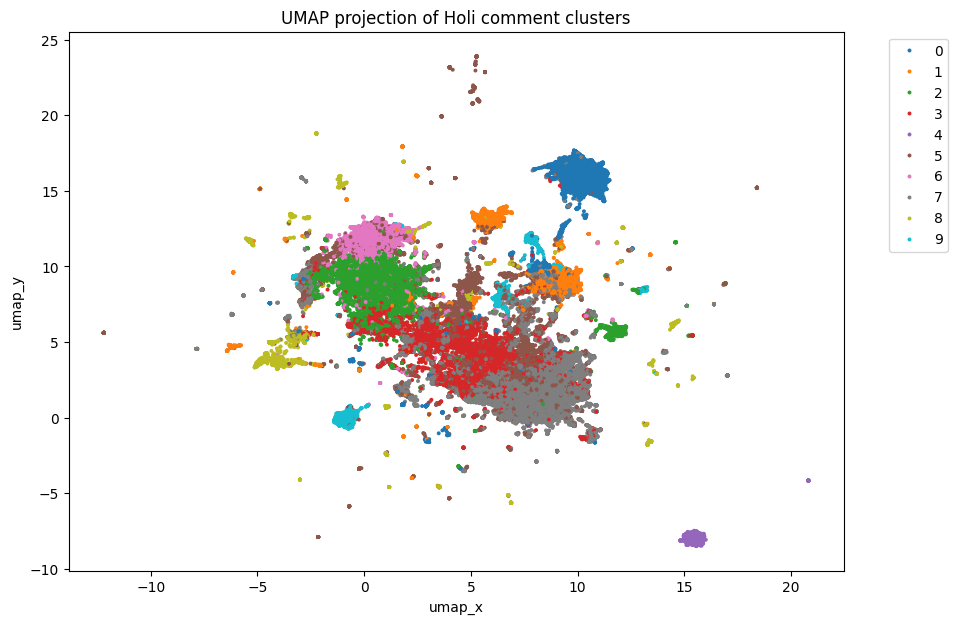

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap

umap_2d = umap.UMAP(n_components=2, random_state=42).fit_transform(embeddings)
df['umap_x'], df['umap_y'] = umap_2d[:,0], umap_2d[:,1]

plt.figure(figsize=(10,7))
sns.scatterplot(data=df, x='umap_x', y='umap_y', hue='cluster', palette='tab10', s=8, linewidth=0)
plt.title("UMAP projection of Holi comment clusters")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


#Step 8 — Save Output

In [14]:
df.to_csv("holi_clustered_results.csv", index=False)
print("✅ Saved to holi_clustered_results.csv")


✅ Saved to holi_clustered_results.csv


In [1]:
import numpy as np

# Load saved embeddings
embeddings = np.load(r"E:\APPLICATIONS\CODING\Intern Work\Toeho\Social Media Mining\BhojpuriMusic\data\embeds\holi_embeddings.npy")
print("Embeddings shape:", embeddings.shape)


Embeddings shape: (170614, 768)


In [2]:
from sklearn.cluster import KMeans

# Run clustering again on embeddings
kmeans = KMeans(n_clusters=10, random_state=42)
labels = kmeans.fit_predict(embeddings)

In [3]:
# Step X — Cluster Quality Scoring (Elbow & Silhouette)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

k_range = range(5, 13)  # test K = 5 to 12
inertia = []            # for elbow
silhouette_scores = []  # for silhouette

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(embeddings)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(embeddings, labels))

# --- Plot Elbow ---
plt.figure(figsize=(10,4))
plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method (KMeans Inertia)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (within-cluster SSE)")
plt.grid(True)
plt.show()

# --- Plot Silhouette ---
plt.figure(figsize=(10,4))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title("Silhouette Scores")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Print best silhouette
best_k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"✅ Best silhouette score = {max(silhouette_scores):.3f} at k={best_k}")


KeyboardInterrupt: 